# Importing libraries

In [1]:
import os # Configure which GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    no_preview = True # deactivate preview
except:
    if os.getenv("SIONNA_NO_PREVIEW"):
        no_preview = True
    else:
        no_preview = False

resolution = [480,320] # increase for higher quality of renderings

# Define magic cell command to skip a cell if needed
from IPython.core.magic import register_cell_magic
from IPython import get_ipython

@register_cell_magic
def skip_if(line, cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)

# Set random seed for reproducibility
sionna.config.seed = 42

In [2]:
from sionna.rt import load_scene, Camera, Transmitter, Receiver, PlanarArray, RadioMaterial, LambertianPattern

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math

# Loading and setting scene properties

Loading scene

In [4]:
scene = load_scene("blender/scene_cm.xml")

Creating custom materials

In [5]:
polycarbonate = RadioMaterial("polycarbonate",
                              relative_permittivity=3,
                              conductivity=0.001,
                              scattering_coefficient=0.3,
                              xpd_coefficient=0.1,
                              scattering_pattern=LambertianPattern())

cardboard  = RadioMaterial("cardboard",
                           relative_permittivity=2.3,
                           conductivity=0.001,
                           scattering_coefficient=0.3,
                           xpd_coefficient=0.1,
                           scattering_pattern=LambertianPattern())

plastic = RadioMaterial("plastic",
                        relative_permittivity=2.8,
                        conductivity=0.0001,
                        scattering_coefficient=0.3,
                        xpd_coefficient=0.1,
                        scattering_pattern=LambertianPattern())

ceramic  = RadioMaterial("ceramic",
                         relative_permittivity=6,
                         conductivity=0.0001,
                         scattering_coefficient=0.3,
                         xpd_coefficient=0.1,
                         scattering_pattern=LambertianPattern())

Selecting scene parts made from custom materials

In [6]:
Polycarbonate_parts = scene.get("Polycarbonate_parts")
Paper_boxes = scene.get("Paper_boxes") 
Plastic_parts = scene.get("Plastic_parts")  
Ceramic_parts = scene.get("Ceramic_parts")

Assigning custom materials to the scene

In [7]:
Polycarbonate_parts.radio_material = polycarbonate 
Paper_boxes.radio_material = cardboard 
Plastic_parts.radio_material = plastic 
Ceramic_parts.radio_material = ceramic

Setting scene parameters

In [8]:
scene.frequency = 60.48e9 # in Hz; implicitly updates RadioMaterials
scene.bandwidth = 512e6
scene.synthetic_array = True # If set to False, ray tracing will be done per antenna element (slower for large arrays)

# Function calculating coverage maps based on inputs

In [9]:
def coverage_map_fnc(tx_position, tx_orientation, cm_height, pattern): 

    scene.remove("tx")
        
    # Configure antenna array for all transmitters
    scene.tx_array = PlanarArray(num_rows=1, #16
                             num_cols=1, #4
                             vertical_spacing=0.1,
                             horizontal_spacing=0.1,
                             pattern=pattern,
                             polarization="H")

    # Configure antenna array for all receivers
    scene.rx_array = PlanarArray(num_rows=1, #16
                             num_cols=1, #16
                             vertical_spacing=0.1,
                             horizontal_spacing=0.1,
                             pattern=pattern,
                             polarization="H")

    # Create transmitter
    tx = Transmitter(name="tx",
                 color=tf.Variable((1, 0, 0), dtype=tf.float32),
                 position=tx_position, 
                 orientation=[0,0,0])
    tx.power_dbm = 41
    tx.look_at(tx_orientation) # Transmitter points towards point
    
    # Add transmitter instance to scene
    scene.add(tx)

    # Create a receiver
    rx = Receiver(name="rx",
              color=tf.Variable((1, 0, 0), dtype=tf.float32),
              position=tf.Variable([0,0,0], dtype=tf.float32),
              orientation=tf.Variable([0,0,0], dtype=tf.float32))

    # Add receiver instance to scene
    #scene.add(rx)

    # Compute coverage map 
    cm = scene.coverage_map(max_depth=5,           # Maximum number of ray scene interactions
                        num_samples=int(10e6), # If you increase: less noise, but more memory required
                        cm_cell_size=(0.1, 0.1),
                        cm_center=[5,2.5,cm_height],
                        cm_orientation = [0,0,0],
                        cm_size = [11,6]) 
    
    return cm

# Camera settings

In [10]:
bird_cam = Camera("cm", position=[5,2.2,20], look_at=[5,2.2,0])
scene.add(bird_cam)

# Coverage maps for different positions

Position 1 - lower right corner at a height of 2.5 m

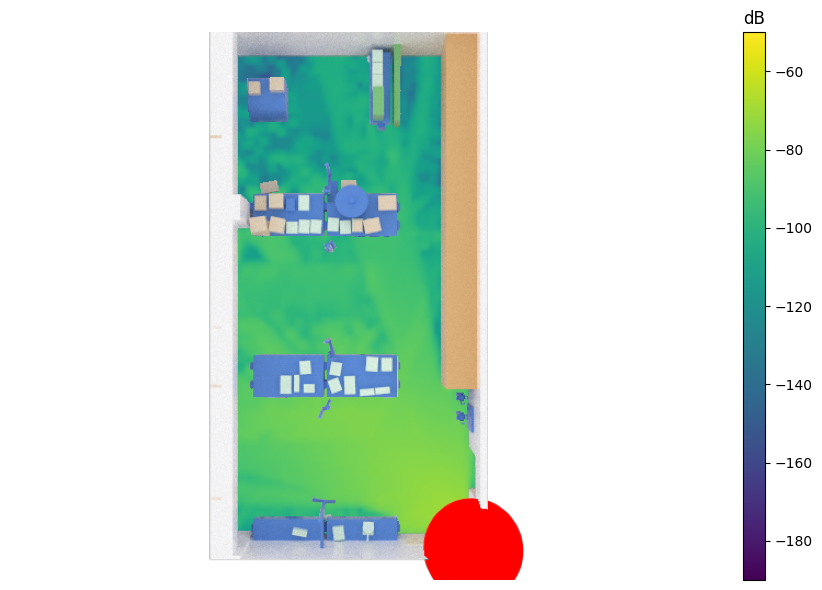

In [11]:
cm1 = coverage_map_fnc(tx_position=[0.1,0.1,2.5], tx_orientation=[0,0,0], cm_height=1, pattern="iso") 
scene.render(camera="cm", coverage_map=cm1, show_devices=True, num_samples=512, cm_vmin =-190, cm_vmax=-50);

Position 2 - lower middle section on the table

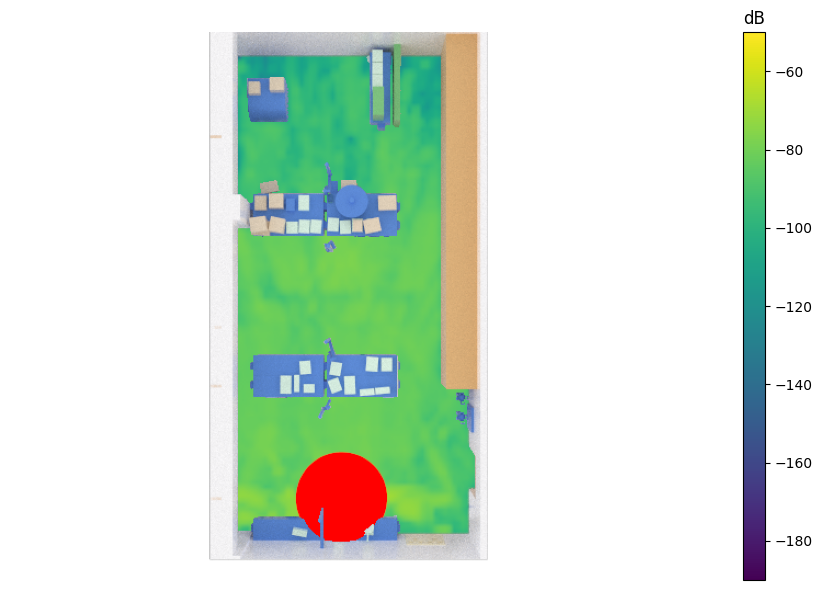

In [12]:
cm2 = coverage_map_fnc(tx_position=[0.8,2.8,1], tx_orientation=[0,0,0], cm_height=1, pattern="iso") 
scene.render(camera="cm", coverage_map=cm2, show_devices=True, num_samples=512, cm_vmin =-190, cm_vmax=-50);

Position 3 - lower left corner above the measuring station

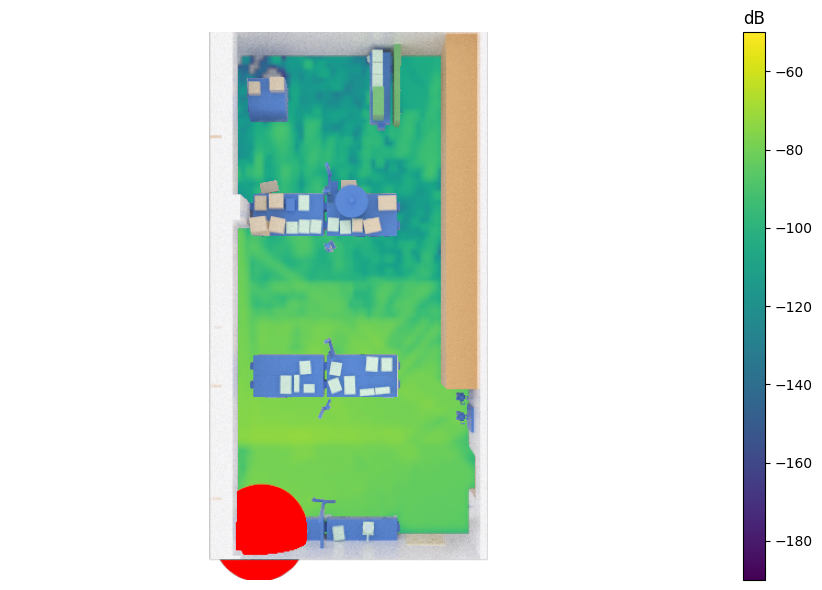

In [13]:
cm3 = coverage_map_fnc(tx_position=[0.2,4.5,1.6], tx_orientation=[0,0,0], cm_height=1, pattern="iso") 
scene.render(camera="cm", coverage_map=cm3, show_devices=True, num_samples=512, cm_vmin =-190, cm_vmax=-50);

Position 4 - middle section on the table

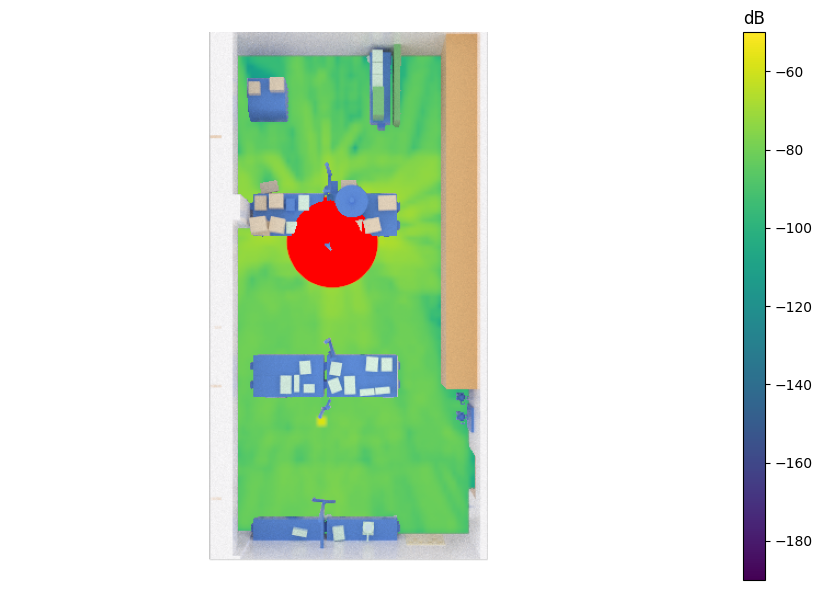

In [14]:
cm4 = coverage_map_fnc(tx_position=[6.4,3,1], tx_orientation=[0,0,0], cm_height=1, pattern="iso") 
scene.render(camera="cm", coverage_map=cm4, show_devices=True, num_samples=512, cm_vmin =-190, cm_vmax=-50);

Position 5 - middle section above the measuring station

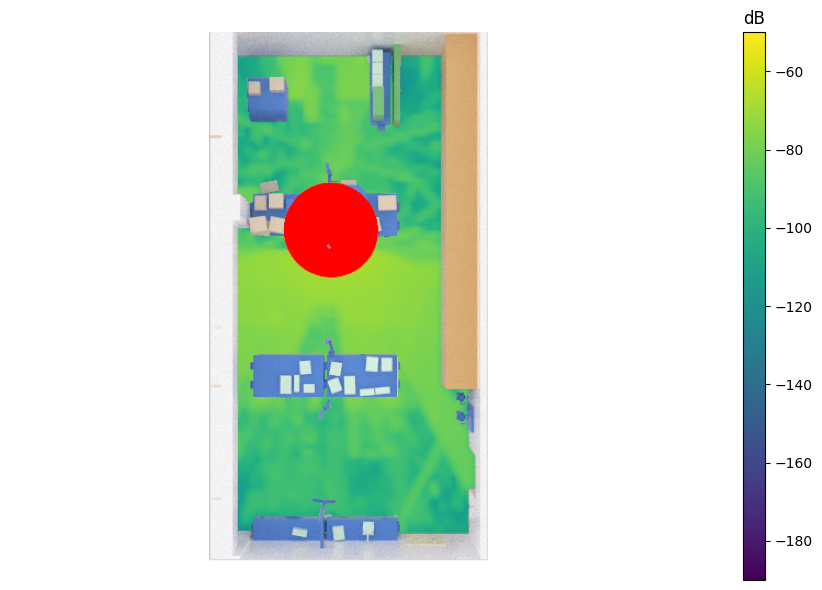

In [15]:
cm5 = coverage_map_fnc(tx_position=[6.6,3,1.7], tx_orientation=[0,0,0], cm_height=1, pattern="iso") 
scene.render(camera="cm", coverage_map=cm5, show_devices=True, num_samples=512, cm_vmin =-190, cm_vmax=-50);

Position 6 - upper left corner above the measuring station

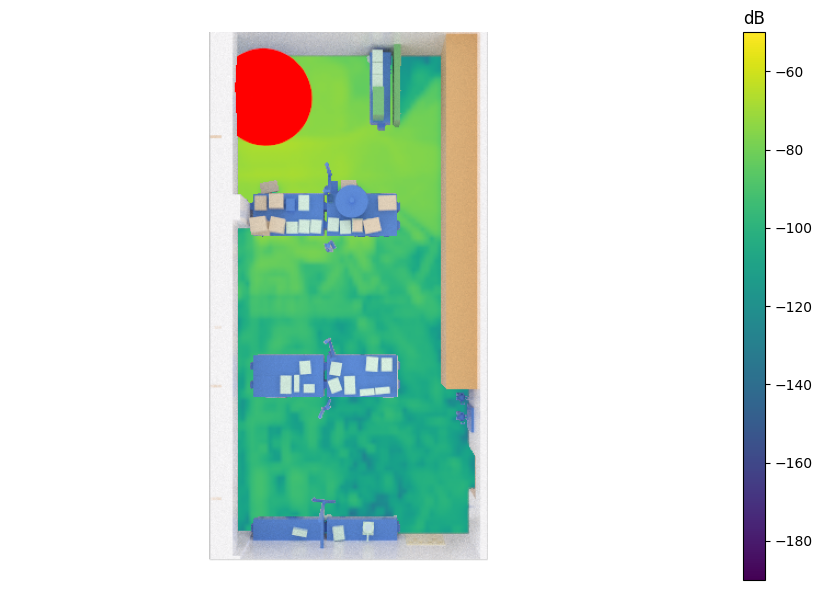

In [16]:
cm6 = coverage_map_fnc(tx_position=[9.4,4.4,1.7], tx_orientation=[0,0,0], cm_height=1, pattern="iso") 
scene.render(camera="cm", coverage_map=cm6, show_devices=True, num_samples=512, cm_vmin =-190, cm_vmax=-50);

Position 7 - upper right corner above the cabinet

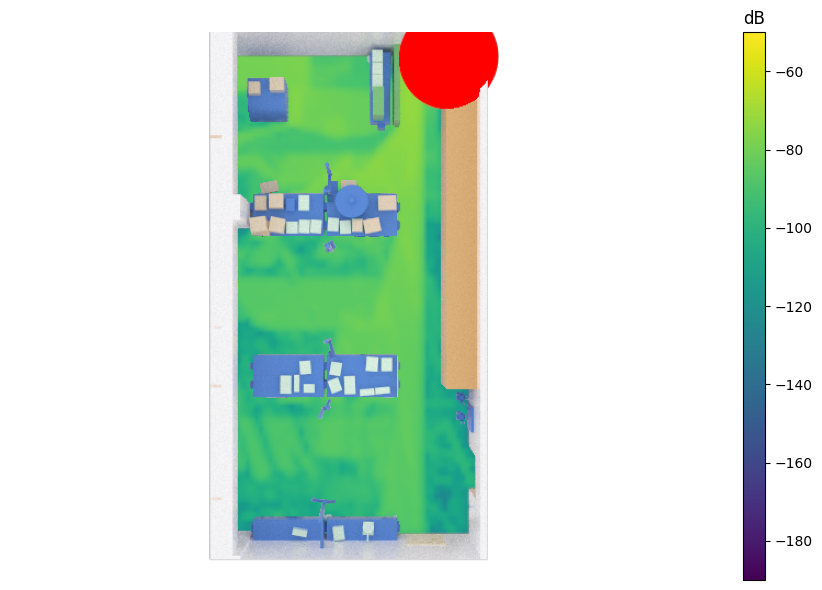

In [17]:
cm7 = coverage_map_fnc(tx_position=[10,0.6,2.5], tx_orientation=[0,0,0], cm_height=1, pattern="iso") 
scene.render(camera="cm", coverage_map=cm7, show_devices=True, num_samples=512, cm_vmin =-190, cm_vmax=-50);

Position 8 - middle right section above the cabinet

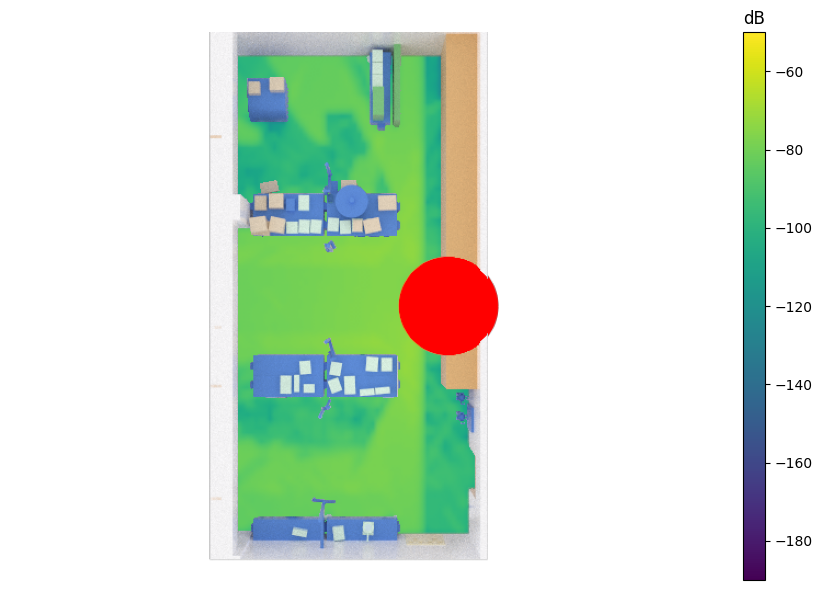

In [18]:
cm8 = coverage_map_fnc(tx_position=[5,0.6,2.5], tx_orientation=[0,0,0], cm_height=1, pattern="iso") 
scene.render(camera="cm", coverage_map=cm8, show_devices=True, num_samples=512, cm_vmin =-190, cm_vmax=-50);

# Coverage maps for different orientations

Orientation 1 - upper right corner

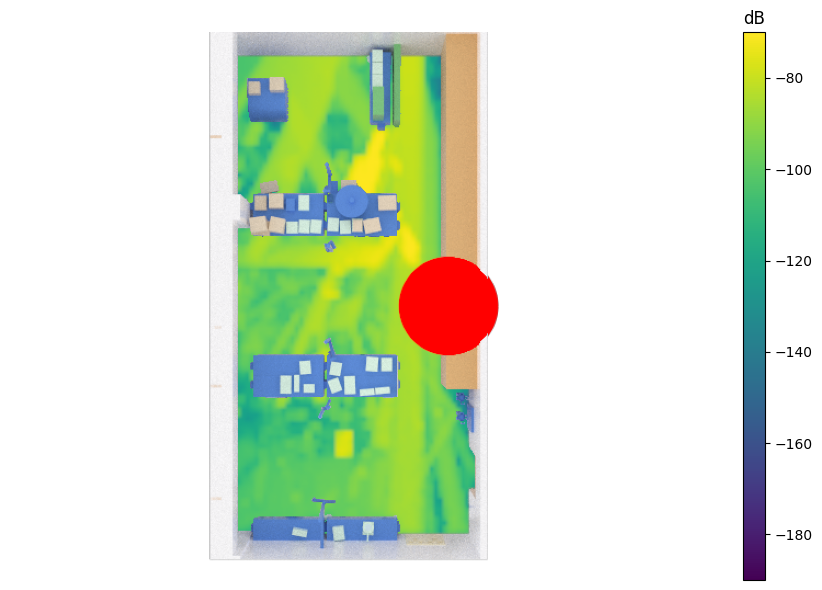

In [19]:
cm9 = coverage_map_fnc(tx_position=[5,0.6,2.5], tx_orientation=[10,0.6,1], cm_height=1, pattern="tr38901") 
scene.render(camera="cm", coverage_map=cm9, show_devices=True, num_samples=512, cm_vmin =-190, cm_vmax=-70);

Orientation 2 - upper left corner

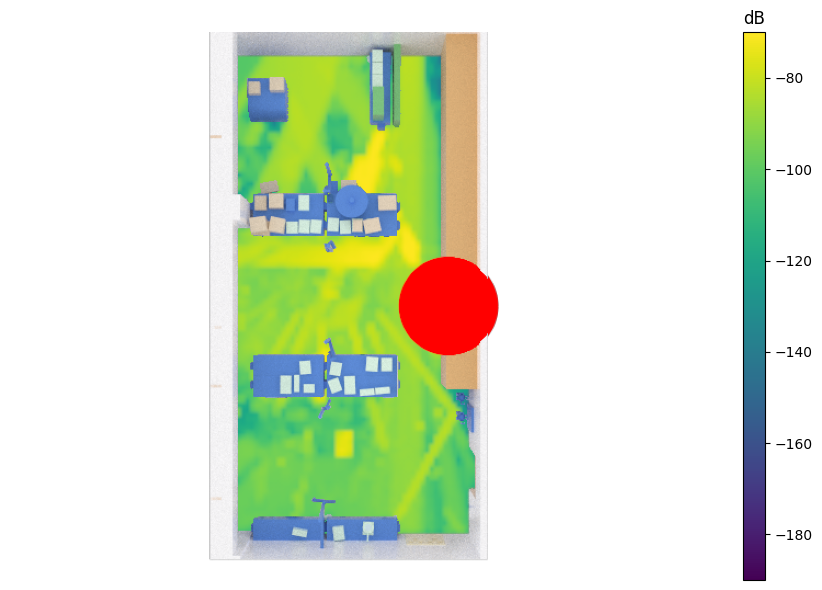

In [20]:
cm10 = coverage_map_fnc(tx_position=[5,0.6,2.5], tx_orientation=[10,5,1], cm_height=1, pattern="tr38901") 
scene.render(camera="cm", coverage_map=cm10, show_devices=True, num_samples=512, cm_vmin =-190, cm_vmax=-70);

Orientation 3 - middle of the left wall

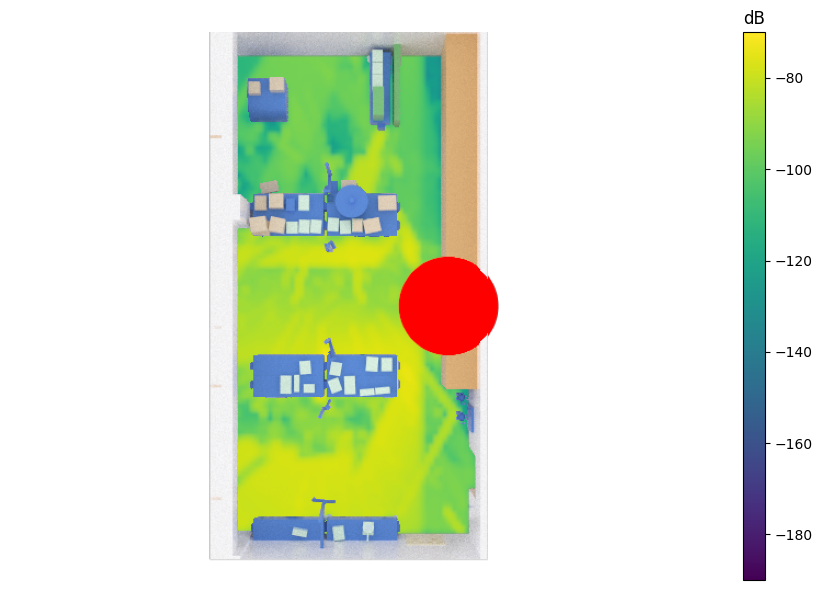

In [21]:
cm11 = coverage_map_fnc(tx_position=[5,0.6,2.5], tx_orientation=[5,5,1], cm_height=1, pattern="tr38901") 
scene.render(camera="cm", coverage_map=cm11, show_devices=True, num_samples=512, cm_vmin =-190, cm_vmax=-70);

Orientation 4 - lower left corner

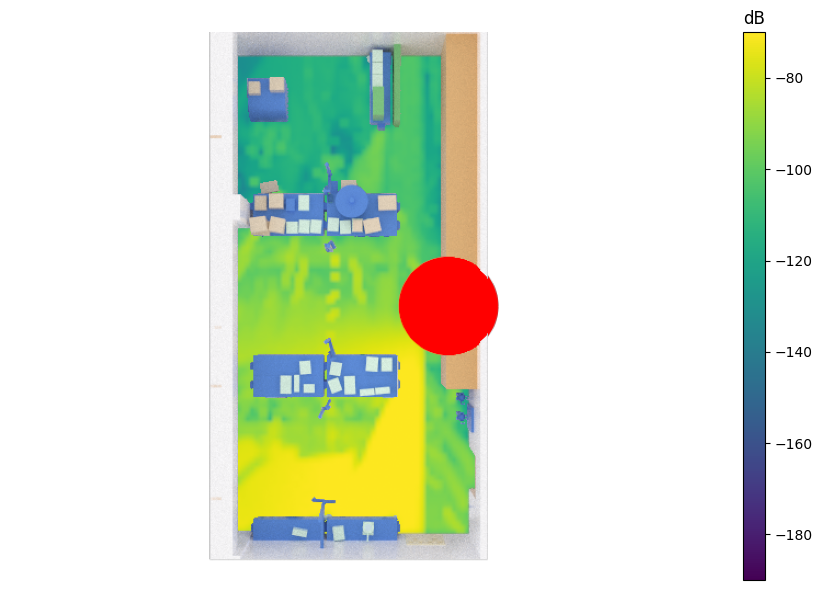

In [22]:
cm12 = coverage_map_fnc(tx_position=[5,0.6,2.5], tx_orientation=[0,5,1], cm_height=1, pattern="tr38901") 
scene.render(camera="cm", coverage_map=cm12, show_devices=True, num_samples=512, cm_vmin =-190, cm_vmax=-70);

Orientation 5 - lower right corner

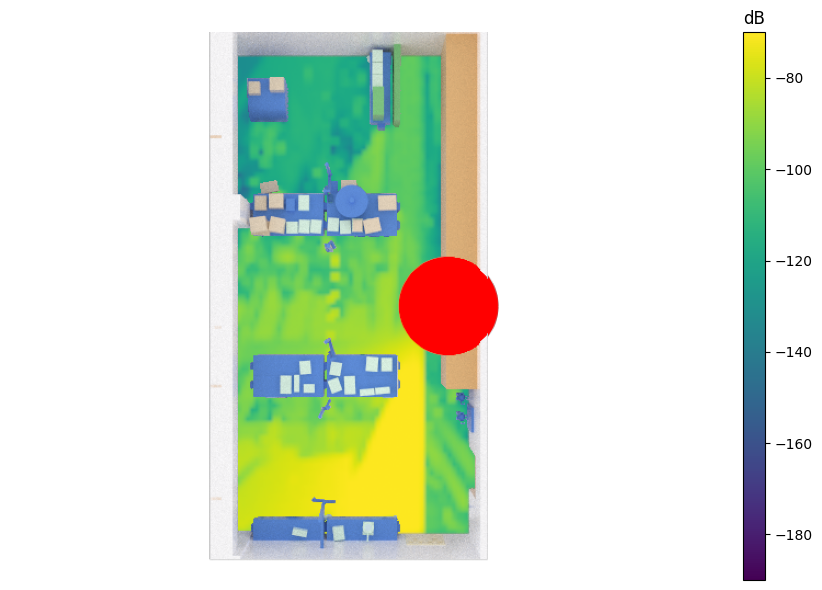

In [23]:
cm13 = coverage_map_fnc(tx_position=[5,0.6,2.5], tx_orientation=[0,0.6,1], cm_height=1, pattern="tr38901") 
scene.render(camera="cm", coverage_map=cm13, show_devices=True, num_samples=512, cm_vmin =-190, cm_vmax=-70);

Orientation 6 - middle of the right wall

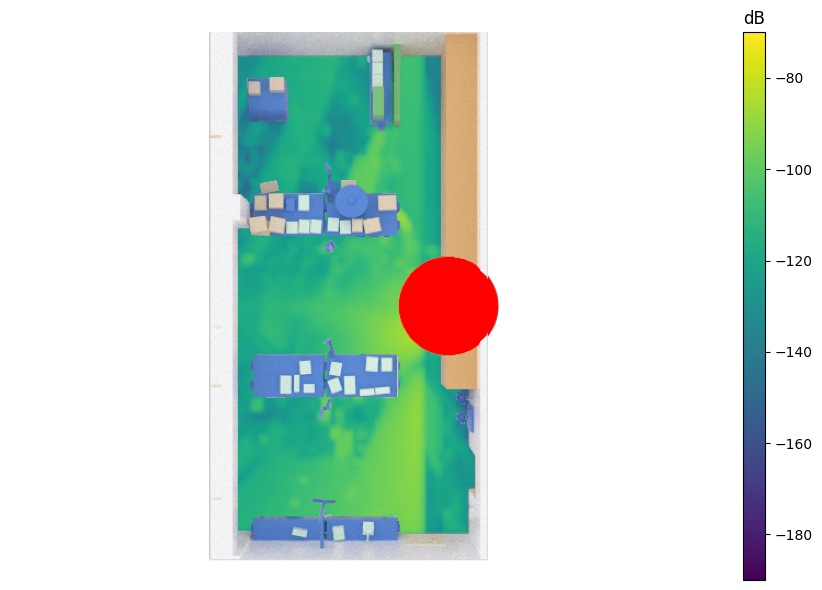

In [24]:
cm14 = coverage_map_fnc(tx_position=[5,0.6,2.5], tx_orientation=[5,0,1], cm_height=1, pattern="tr38901") 
scene.render(camera="cm", coverage_map=cm14, show_devices=True, num_samples=512, cm_vmin =-190, cm_vmax=-70);

# Coverage maps for different heights

Height 0 m

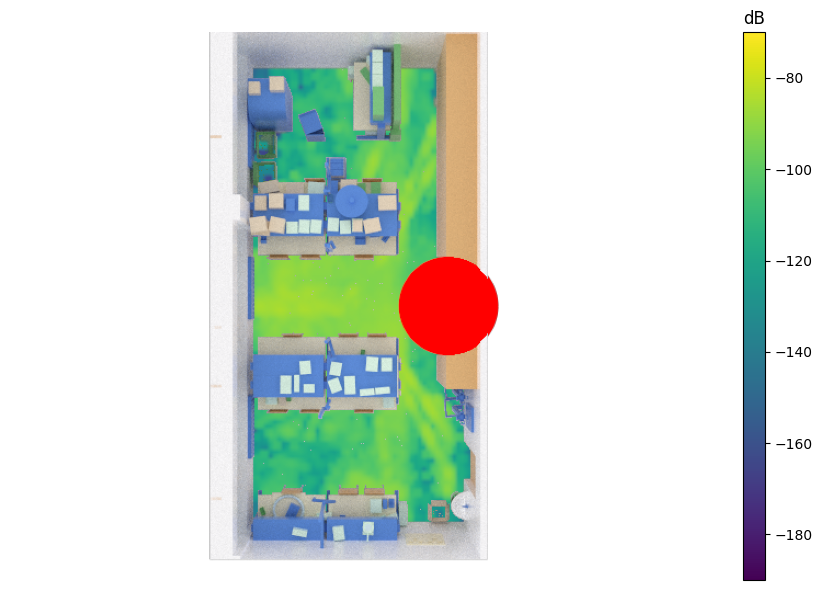

In [25]:
cm15 = coverage_map_fnc(tx_position=[5,0.6,2.5], tx_orientation=[0,0,0], cm_height=0, pattern="iso") 
scene.render(camera="cm", coverage_map=cm15, show_devices=True, num_samples=512, cm_vmin =-190, cm_vmax=-70);

Height 0.5 m

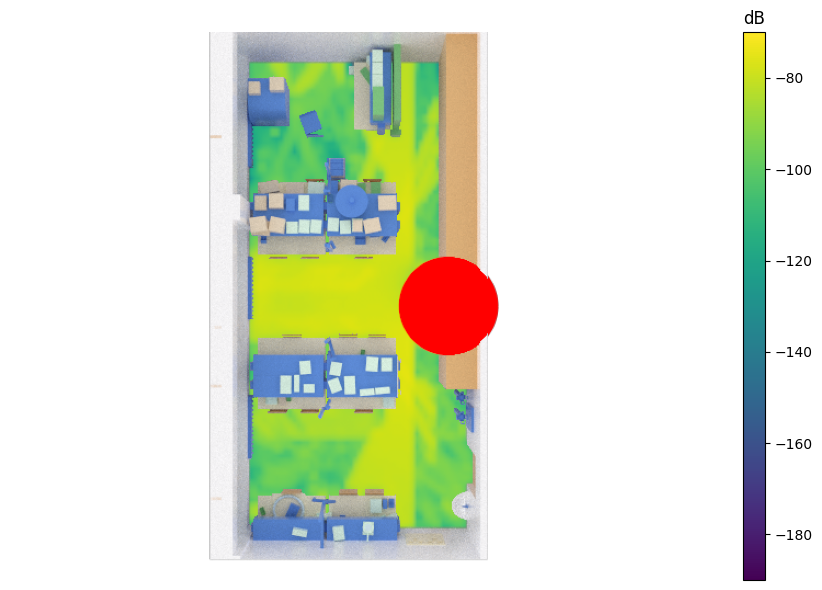

In [26]:
cm16 = coverage_map_fnc(tx_position=[5,0.6,2.5], tx_orientation=[0,0,0], cm_height=0.5, pattern="iso") 
scene.render(camera="cm", coverage_map=cm16, show_devices=True, num_samples=512, cm_vmin =-190, cm_vmax=-70);

Height 1 m

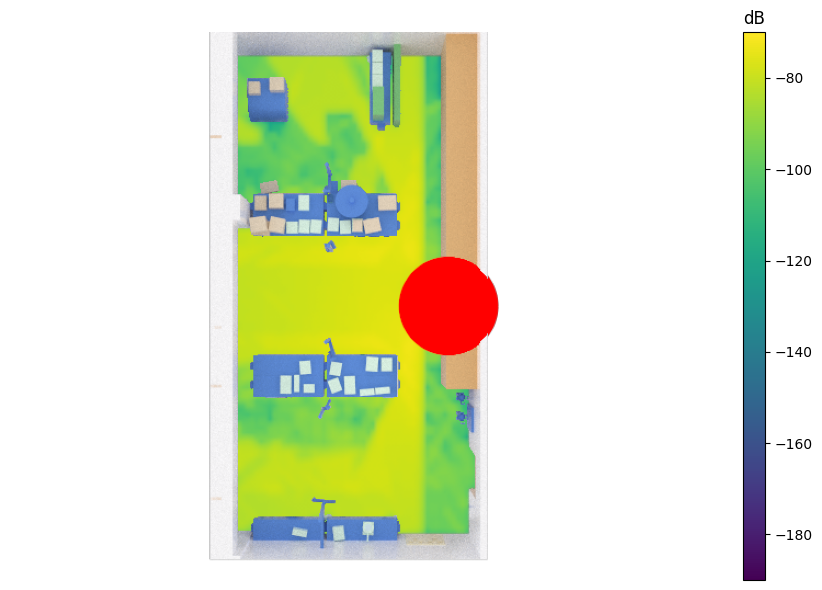

In [27]:
cm17 = coverage_map_fnc(tx_position=[5,0.6,2.5], tx_orientation=[0,0,0], cm_height=1, pattern="iso") 
scene.render(camera="cm", coverage_map=cm17, show_devices=True, num_samples=512, cm_vmin =-190, cm_vmax=-70);

Height 1.5 m

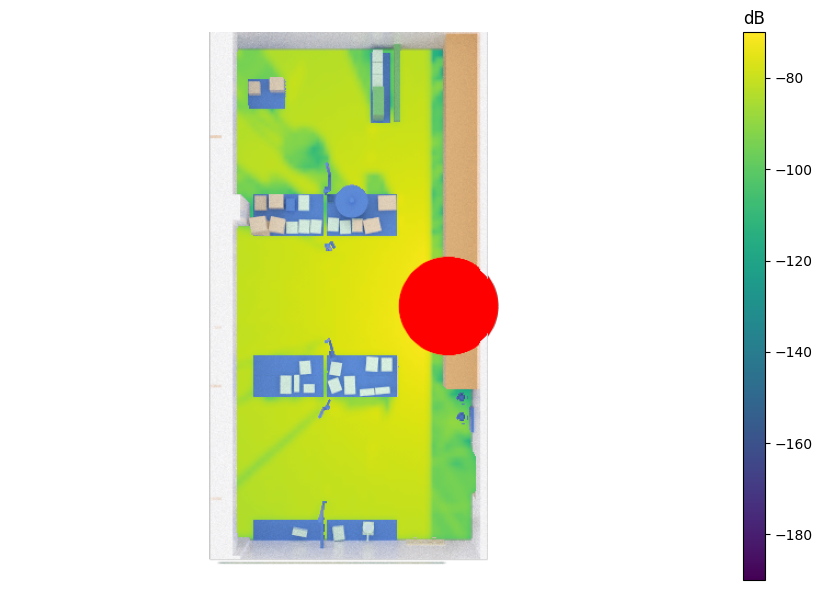

In [28]:
cm18 = coverage_map_fnc(tx_position=[5,0.6,2.5], tx_orientation=[0,0,0], cm_height=1.5, pattern="iso") 
scene.render(camera="cm", coverage_map=cm18, show_devices=True, num_samples=512, cm_vmin =-190, cm_vmax=-70);

Height 2 m

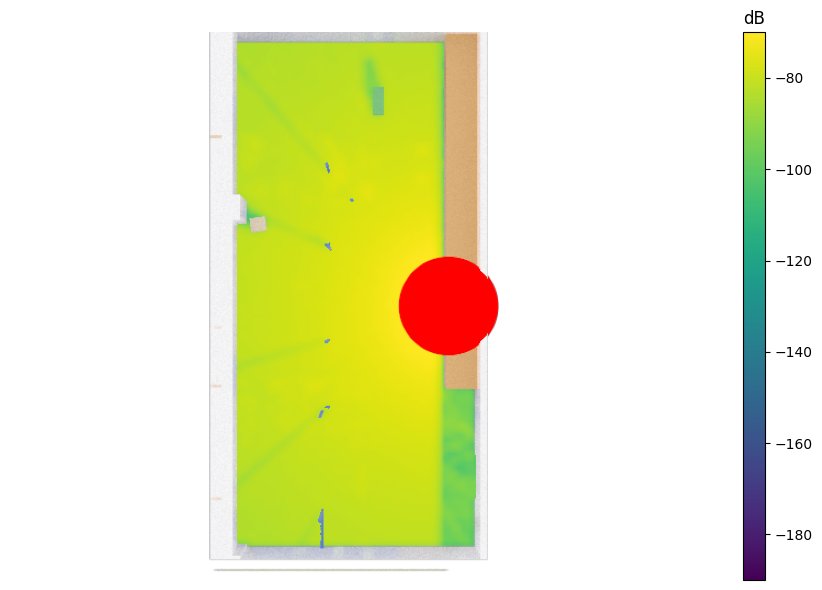

In [29]:
cm19 = coverage_map_fnc(tx_position=[5,0.6,2.5], tx_orientation=[0,0,0], cm_height=2, pattern="iso") 
scene.render(camera="cm", coverage_map=cm19, show_devices=True, num_samples=512, cm_vmin =-190, cm_vmax=-70);